In [74]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

import matplotlib.pylab as pylab
#pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [75]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilatacija(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erozija(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)
def scale_to_range(image): #skalira elemente slike na opseg od 0 do 1
    return image/255
def select_candidates(original, image_bin):
    import collections
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    regioni = {}
    for contour in contours: # za svaku konturu   
        x,y,w,h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h>15 and w>20:
            region = cv2.resize(image_bin[y:y+h+1,x:x+w+1],(28,28), interpolation = cv2.INTER_NEAREST)##resize
            regioni[x] = region       
            cv2.rectangle(original,(x,y),(x+w,y+h),(0,255,0),2)
    sortiran = collections.OrderedDict(sorted(regioni.items()))
    return original, sortiran

def prepare_for_NN(regions):
    ready = []
    for region in regions:
        ready.append(scale_to_range(region))
    return ready


In [76]:
image_color = load_image('images/brojevi.png')
img = invert(image_bin(image_gray(image_color)))

10


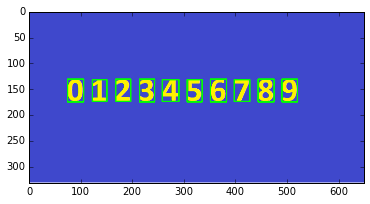

In [80]:
img_bin = erozija(dilatacija(img))
selected, numbers = select_candidates(image_color.copy(),img)
print len(prepare_for_NN(numbers))
display_image(selected)
